# Time Lag Neural Network ERA5-Daten (Vergangenheit)

Als erster Schritt werden alle für die Analyse benötigten Bibliotheken geladen:
- numpy: Datenstruktur und mathematische Operationen <https://numpy.org/doc/2.3/user/index.html>
- pandas: Tabellen, Datenverarbeitung <https://pandas.pydata.org/docs/user_guide/index.html#user-guide>
- sklearn: Skalierung der Eingabe und Ausgabedaten, Modellbewertungskriterien <https://scikit-learn.org/stable/api/index.html>
- tensorflow.keras: Modellarchitektur, Training und Vorhersage <https://www.tensorflow.org/api_docs/python/tf/keras]>

Anschließend wird die zuvor erstelle CSV-Datei(merged_era5_tas_prec_discharge.csv) geladen, die die gemittelte Temperatur und den gemittelten Niederschlag für das Einzugsgebiet der Murg sowie den Abfluss (Tagesmittel) der Murg enthält.

In [1]:
# Alle Bibliotheken laden, die benötigt werden

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import os

# Daten laden
df = pd.read_csv("https://raw.githubusercontent.com/emorl/projektstudie-murgtal/main/1_daten/era5_tas_prec_discharge_merge.csv", parse_dates=["date"]) 
df = df.sort_values("date")  

df.head()
df.tail()

,date,t2m_mean,tp_sum,flow_m3_s
15700,2023-12-27,5.799423,0.041605,40.142
15701,2023-12-28,7.512945,4.821156,30.271
15702,2023-12-29,8.308515,0.707908,25.683
15703,2023-12-30,7.004020,0.339450,28.834
15704,2023-12-31,4.911555,3.817253,24.258


# Time Lag Neural Network erstellen, trainieren und testen

In diesem Codeabschnitt wird das neuronale Netz zur Vorhersage des Abflusses (flow_m3_s) auf Basis der verzögerten Temperatur-, Niederschlagsdaten trainiert.

Zuerst werden aus dem Original-Datensatz Lag-Features (3 Tage Rückschau) für Temperatur, Niederschlag und Abfluss erstellt. Anschließend werden die Daten in Trainings-, Validierungs- und Testsets aufgeteilt und mit dem StandardScaler standardisiert (Mittelwert = 0, Standardabweichung = 1).

Ein Feed-Forward-Neuronales Netz mit drei versteckten Schichten und Dropout (zur Vermeidung von Overfitting) wird erstellt und mit dem Adam-Optimierer trainiert. Dabei wird EarlyStopping verwendet, um das Training zu beenden, wenn sich der Validierungsfehler über 10 Epochen nicht verbessert.

Zum Schluss wird das Modell verwendet, um Abflusswerte im Testdatensatz vorherzusagen.

In [2]:
# Funktion erstellen, die Lag-Features enthält, lags = gibt die Anzahl der Verzögerungsschritte an
def create_lag_features_with_flow(df, lags=3):
    df_lagged = df.copy() # Kopie des Orgiginaldatensatzes erstellen um Überschreibungen zu vermeiden

    for lag in range(1, lags + 1): #Schleife erstellen für alle Lags
        df_lagged[f"tas_lag_{lag}"] = df_lagged["t2m_mean"].shift(lag) # Spalte mit verzögerten Temperaturwerten
        df_lagged[f"prec_lag_{lag}"] = df_lagged["tp_sum"].shift(lag) # Spalte mit verzögerten Niederschlagswerten
        df_lagged[f"flow_lag_{lag}"] = df_lagged["flow_m3_s"].shift(lag)  # Spalte mit verzögerten Abflusswerten

    df_lagged = df_lagged.dropna() # NAs entfernen, die durch das verschieben entstehen
    return df_lagged # Rückgabe des DataFrames der die Lags beinhaltet

# df mit 3 lags verwenden
df_lagged = create_lag_features_with_flow(df) 

# Inputdaten sind Temperatur und Niederschlag (Datum und Abfluss werden entfernt) (X), Zielwert ist der Abfluss (y)
X = df_lagged.drop(columns=["date", "flow_m3_s"])
y = df_lagged["flow_m3_s"]

# Daten zeitlich splitten in: Training 60%, Validierung 20% und Test 20%
# Info: Wir haben den Split im Vergleich zum Exposé von 70-20-10 auf 60-20-20 geändert, damit der Testzeitraum größer ist und dadurch das Modell tendenziell zuverlässiger wird. 
# Dadurch unterscheiden sich die Zeiträume für Training, Validierung und Test im Vergleich zum Exposé etwas.
n = len(X)
train_size = int(n * 0.6)
val_size = int(n * 0.2)

# Daten aufteilen in Training, Validierung und Test
X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]
X_val   = X.iloc[train_size:train_size + val_size]
y_val   = y.iloc[train_size:train_size + val_size]
X_test  = X.iloc[train_size + val_size:]
y_test  = y.iloc[train_size + val_size:]

# Eingabewerte skalieren 
x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_val_scaled   = x_scaler.transform(X_val)
X_test_scaled  = x_scaler.transform(X_test)

# Zielwerte ebenfalls skalieren
y_train_reshaped = y_train.values.reshape(-1, 1)
y_val_reshaped   = y_val.values.reshape(-1, 1)
y_test_reshaped  = y_test.values.reshape(-1, 1)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train_reshaped)
y_val_scaled   = y_scaler.transform(y_val_reshaped)
y_test_scaled  = y_scaler.transform(y_test_reshaped)

# Modell: 3 versteckte Schichten, Aktivierungsfunktion relu
model_compact = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.1),

    Dense(64, activation='relu'),
    Dropout(0.1),

    Dense(32, activation='relu'),

    Dense(1)  # Output Layer
])

# Kompilierung des Modells mit Adam optimizer und MSE-Loss, MSE = Mean Squared Error
model_compact.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='mse',
    metrics=['mae']
)

# early_stopping stoppt das Training, wenn sich der val_loss nicht nach 10 Durchläufen verbessert
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Training des Modells mit early_stopping
history_compact = model_compact.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Vorhersage und Rückskalierung der Ausgabewerte um echte Werte zu erhalten
y_pred_scaled_compact = model_compact.predict(X_test_scaled)
y_pred_compact = y_scaler.inverse_transform(y_pred_scaled_compact)

# Rückskalierung der echten Testwerte
y_test_orig_compact = y_scaler.inverse_transform(y_test_scaled)


Epoch 1/200


/Users/emmamorlock/master_ki_deeplearning/env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6272 - mae: 0.3709 - val_loss: 0.1431 - val_mae: 0.1770
Epoch 2/200
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 0.2198 - mae: 0.2164 - val_loss: 0.1619 - val_mae: 0.1762
Epoch 3/200
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 0.1629 - mae: 0.2038 - val_loss: 0.1517 - val_mae: 0.1680
Epoch 4/200
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - loss: 0.1611 - mae: 0.1965 - val_loss: 0.1371 - val_mae: 0.1549
Epoch 5/200
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 0.1847 - mae: 0.1975 - val_loss: 0.1549 - val_mae: 0.1642
Epoch 6/200
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 0.1355 - mae: 0.1824 - val_loss: 0.1358 - val_mae: 0.1703
Epoch 7/200
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 0.1357 - mae: 0.1836 - val_loss: 0.1415 - val_mae: 0.1663
Epoch 8/200
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 0.1328 - mae: 0.1801 - val_loss: 0.1435 - val_mae: 0.1584
Epoch 9/200
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 94

In [11]:
import joblib # nötig zum Speichern der Scaler

# Scaler speichern für Anwendung auf RCP-Szenarien
joblib.dump(x_scaler, "hier-lokalen-Pfad-definieren/1_daten/model_architcture/x_scaler.pkl")
joblib.dump(y_scaler, "hier-lokalen-Pfad-definieren/1_daten/model_architcture/y_scaler.pkl")

['data/y_scaler.pkl']

# Modellbewertung

Mit Hilfe des Mean Absolute Error (MAE) und  R² können die echten und vorhergesagten Werte bewertet werden. 

In [5]:
# Bewertungsmetriken aus sklearn importieren: Mean Absolute Error (MAE) und  R² 
from sklearn.metrics import mean_absolute_error, r2_score

# MAE und R² zwischen echten und vorhergesagten Werten berechnen und anzeigen lassen
mae_compact = mean_absolute_error(y_test_orig_compact, y_pred_compact)
r2_compact = r2_score(y_test_orig_compact, y_pred_compact)

print(f"Test MAE : {mae_compact:.3f}")
print(f"Test R² : {r2_compact:.3f}")

Test MAE : 2.724
Test R² : 0.870


Der Test-MAE beträgt 2.72, was bedeutet, dass die Vorhersagen im Durchschnitt um 2.72 Einheiten vom tatsächlichen Abflusswert abweichen.
Der Test-R²-Wert beträgt 0.87, was bedeutet, dass das Modell etwa 87 % der Varianz in den echten Abflusswerten erklärt. 

In [12]:
model_compact.save("hier-lokalen-Pfad-definieren/1_daten/model_architcture/model_lag3.keras")

Damit das Modell auf die beiden RCP-Szenarien angewandt werden kann und ein zukünftiger Abfluss unter diesen Szenarien prognositziert werden kann, wird es gespeichert.

# Visualiserung

Die Abbildung zeigt die vorhergesagten und tatsächlichen Abflusswerte im Zeitraum von 2015 bis 2024. Es ist deutlich erkennbar, dass die Vorhersagen in weiten Teilen gut mit den realen Werten übereinstimmen. Besonders hohe Abflussmengen werden vom Modell jedoch nicht immer sonderlich gut erfasst, was auf eine begrenzte Fähigkeit zur Vorhersage von Extremwerten hindeutet. Ähnlich verhält es sich mit sehr kleinen Abflussmengen. Eine perfekte Überlappung würde auf Overfitting hindeuten. Das bedeutet, dass das Modell sich zu stark an die Trainingsdaten anpasst und auf neue, unbekannte Daten schlechter generalisiert.

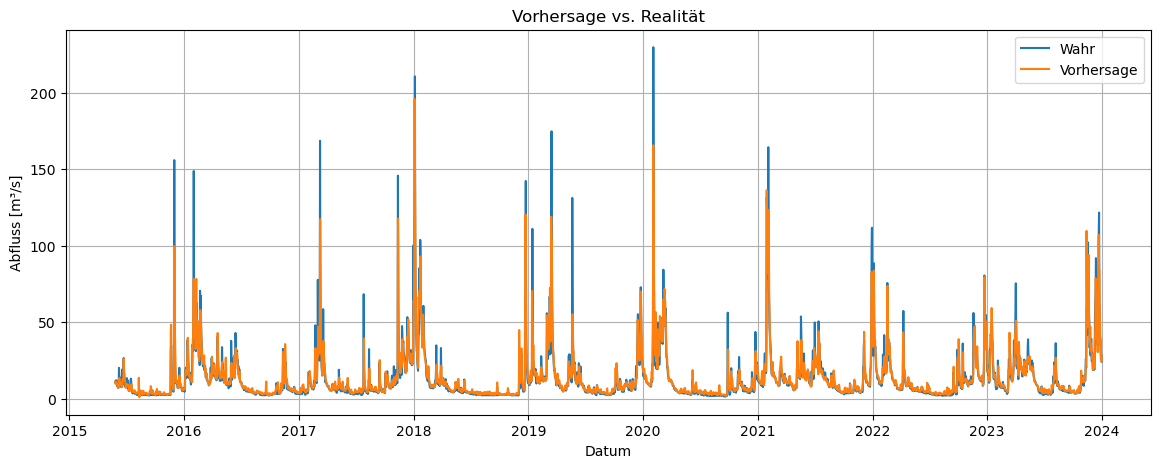

In [9]:
import matplotlib.pyplot as plt

# Model visualisieren
dates = df_lagged["date"].iloc[train_size + val_size:]  # passende Datumswerte

plt.figure(figsize=(14, 5))
plt.plot(dates, y_test_orig_compact, label="Wahr")
plt.plot(dates, y_pred_compact, label="Vorhersage")
plt.title("Vorhersage vs. Realität")
plt.xlabel("Datum")
plt.ylabel("Abfluss [m³/s]")
plt.legend()
plt.grid(True)



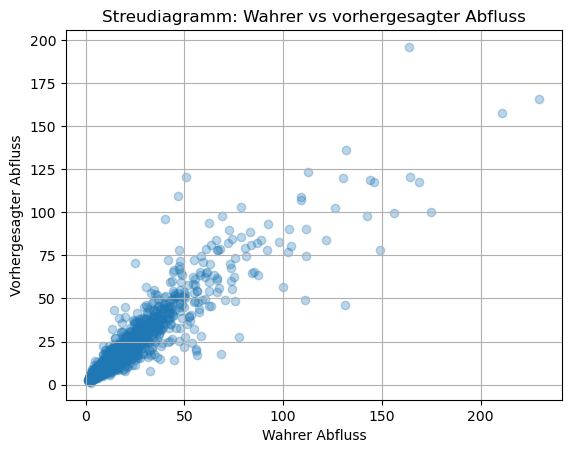

In [10]:
# Streudiagramm plotten
import matplotlib.pyplot as plt
plt.scatter(y_test_orig_compact, y_pred_compact, alpha=0.3)
plt.xlabel("Wahrer Abfluss")
plt.ylabel("Vorhergesagter Abfluss")
plt.title("Streudiagramm: Wahrer vs vorhergesagter Abfluss")
plt.grid(True)

Der Scatterplot zeigt die Beziehung zwischen den tatsächlichen und den vorhergesagten Abflusswerten. Viele Punkte liegen nah an der Diagonalen, was auf eine solide Übereinstimmung zwischen Modell und Realität hinweist.
Es gibt jedoch einige deutliche Ausreißer, insbesondere bei höheren Abflusswerten, was die vorherige Beobachtung bestätigt.